In [1]:
import numpy as np
from scipy.linalg import sqrtm

In [2]:
def sample_entry(M, delta):
    
    print (delta)
    
    for i in range(M.shape[1]):
        sample = np.random.choice(2, M.shape[0], p=[1 - delta, delta])
        M[:, i] = M[:, i] * sample

    return M

In [304]:
def SPCA(C, k):
    omega = np.random.randn(C.shape[1], k)
    
    print ("gauss random matrix shape ", omega.shape)
    
    _C = np.zeros(C.shape)
    # Trimming
    for i in range (C.shape[0]):
        if (np.count_nonzero(C[i,:]) > 10):
            _C[i,:] = 0
        else:
            _C[i,:] = C[i,:]
    print ("_C shape ", _C.shape)        
    
    F = _C.T @ _C - np.diag(np.diag( _C.T @ _C))
    
    print ("F shape ", F.shape)
    
    QR = (np.linalg.matrix_power(F,
                                 int(np.ceil(5 * np.log(C.shape[1])))) @ omega)
    
    print ("QR shape ", QR.shape)
    
    Q, _ = np.linalg.qr(QR)
    
    return Q[:, :k]

In [433]:
def SLA(M, k, delta, l):
    
    M = M.astype(np.float64)
    
    m, n = M.shape[0], M.shape[1]
    print ("k ", k)
    print ("l ", l)
    print ("M shape ", M.shape)
    
    l_samples = list(np.random.choice(n, l, replace=True))
    #l_samples = np.arange(l)
    
    print ("sample len ", len(l_samples))
        
    A_b1 = sample_entry(M[:, l_samples], delta)
    A_b2 = sample_entry(M[:, l_samples], delta)
    print("A_b1 shape ", A_b1.shape)
    #print(A_b1)
    #print(A_b2)
    Q = SPCA(A_b1, k)
    print("Q shape ", Q.shape)
    
    M = np.delete(M, l_samples, 1)
    
    for i in range(m):
        if (np.count_nonzero(A_b2[i, :]) > 2):
            A_b2[i, :] = 0
            
    for i in range(l):
        if (np.count_nonzero(A_b2[:, i]) > 10 * delta * m):
            A_b2[:, i] = 0
    
    W = A_b2 @ Q
    V = np.zeros((n, k))
    
    print("W shape", W.shape)
    print("V shape", V.shape)
    
    V[:l, :] = (A_b1).T @ W
    
    ## FIXME: ??? what size ???
    I = A_b1 @ V[:l, :]
    
    ### TODO: Need to remove A_b1, A_b2 and Q from RAM
    
    for t in range(l, n):
        A_t = M[:, t - l]
        V[t, :] = (A_t.reshape(1, -1)) @ W
        I += (A_t.reshape(-1, 1)) @ V[t, :].reshape(1, -1)
        ## TODO: remove A_t from RAM ???

    print("rank A_b1:", np.linalg.matrix_rank(A_b1))
    print("rank A_b2:", np.linalg.matrix_rank(A_b2))
    print("rank W:", np.linalg.matrix_rank(W))
    print("rank Q:", np.linalg.matrix_rank(Q))
    print("rank V:", np.linalg.matrix_rank(V))
    print("rank I:", np.linalg.matrix_rank(I))
    
    R = sqrtm(V.T @ V)
    R = np.linalg.inv(R)
    
    print("R shape", R.shape)
    
    U = (1.0/delta) * (I @ R @ R.T)
    
    ## FIXME: Need to find out what is here in actual algorithm
    M_k = U @ V.T
    print (M_k.shape)
    
    return M_k      

In [434]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests

url = 'https://cdn.icon-icons.com/icons2/10/PNG/256/check_ok_accept_apply_1582.png'
img_raw = Image.open(requests.get(url, stream=True).raw)
img = np.array(img_raw).astype(np.uint8)

img = img[:,:,3]
image = np.zeros(img.shape).astype(dtype=np.int)
image[img >= 1] = 1


print (image.shape)
print (image)
print (np.count_nonzero(image))
print (image.shape[0] * image.shape[1])

(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
24485
65536


In [435]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

def load_sequence(path, start, stop):
    
    files = os.listdir(path)
    frame = Image.open(os.path.join(path, files[0]))
    frame = frame.convert("L")
    frame = np.array(frame) / 255.0
    
    print(frame.shape)
        
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, stop - start), np.float32)
    
    for i in range(start, stop):
        frame = Image.open(os.path.join(path, files[i])).convert("L")
        frame = np.array(frame)
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size

videos = [
            "./videos/Bootstrap",
            "./videos/Camouflage",
            "./videos/ForegroundAperture",
            "./videos/LightSwitch",
            "./videos/MovedObject",
            "./videos/TimeOfDay",
            "./videos/WavingTrees"
         ]

start = 0
stop = 200
M, frame_size = load_sequence(videos[0], start, stop)

(120, 160)


In [441]:
delta = 0.05

l = 45 #int(1.0 / (delta * np.log(256)))
print(l)

k = 30

print (image)

res = SLA(M, k, delta, l)

45
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
k  30
l  45
M shape  (19200, 200)
sample len  45
0.05
0.05
A_b1 shape  (19200, 45)
gauss random matrix shape  (45, 30)
_C shape  (19200, 45)
F shape  (45, 45)
QR shape  (45, 30)
Q shape  (45, 30)
W shape (19200, 30)
V shape (200, 30)
rank A_b1: 45
rank A_b2: 45
rank W: 30
rank Q: 30
rank V: 30
rank I: 30
(30, 30)
R shape (30, 30)
(19200, 200)


In [442]:
print (np.linalg.matrix_rank(res))

30


In [443]:
print (np.count_nonzero(res))

3840000


dtype('int64')

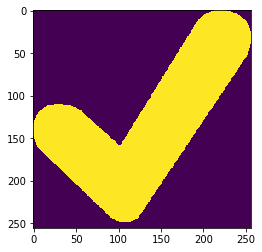

In [444]:
plt.imshow(image);
image.dtype

[[  16.94082757   34.76183775   44.66835518 ...  940.59969617
   896.09817505  829.12580507]
 [ -17.90034491   29.66089029   32.47976693 ...  832.66696618
   857.75959047  751.80288915]
 [ -33.99686816   50.87238458   25.37887819 ...  725.10541508
   779.97203897  712.1553661 ]
 ...
 [ 131.64492623  -29.29974321   15.28799953 ... 2256.53463592
  2267.49008216 2027.78878134]
 [  51.43485039 -218.48216622   55.46143747 ... 2368.23212355
  2152.44943162 2165.1762623 ]
 [ 100.38236444    7.72279459   10.66637965 ... 2081.12254005
  2054.61942053 1824.77906336]]


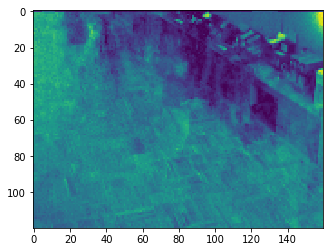

In [455]:
print(res)
plt.imshow(np.abs(res[:, 115].reshape(frame_size)));